In [85]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor as cbr
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

In [86]:
df = pd.read_csv('./data.csv')

In [87]:
df.head()

,dt,MW
0,2011-01-01 00:00:00,3416.0
1,2011-01-01 00:15:00,4755.0
2,2011-01-01 00:30:00,4939.0
3,2011-01-01 00:45:00,4939.0
4,2011-01-01 01:00:00,4998.0


In [88]:
df.tail()

,dt,MW
385561,2021-12-30 06:45:00,8140.31
385562,2021-12-30 07:00:00,8162.33
385563,2021-12-30 07:15:00,8405.11
385564,2021-12-30 07:30:00,8503.48
385565,2021-12-30 07:45:00,8403.53


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385566 entries, 0 to 385565
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   dt      385566 non-null  object 
 1   MW      385566 non-null  float64
dtypes: float64(1), object(1)
memory usage: 5.9+ MB


In [90]:
df.describe()

,MW
count,385566.000000
mean,3183.560481
std,3045.941591
min,0.000000
25%,905.000000
50%,2164.000000
75%,4529.877500
max,16727.500000


In [91]:
df.isnull().sum()

dt    0
MW    0
dtype: int64

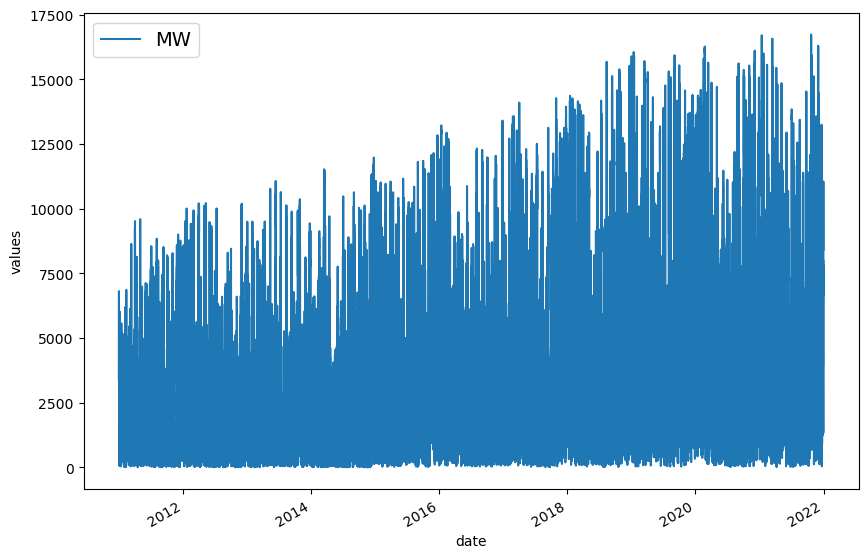

In [137]:
df.plot(figsize=(10, 7))
plt.ylabel("values")
plt.legend(fontsize=14);

У нас есть датасет с данными по выработке энергии ветра в Германии с 1 января 2011 года до 30 декабря 2021 года. Данные записывались каждые 15 минут, всего 385566 значений. Пропущенных значений в датасете нет.  

## Forecasting

Для прогнозирования временного ряда на год вперед будем использовать регрессионную модель CatBoost. Добавим признаки в датасет, разделим ряд на тренировочную и тестовую выборку (размер тестовой выборки будет год) и посчитаем ошибку предсказания MAPE.

In [92]:
df['date'] = pd.to_datetime(df['dt'])
df.set_index('date', inplace=True)

In [93]:
split_date = pd.to_datetime('2020-12-31')

In [94]:
train = df[df.index <= split_date]
test = df[df.index > split_date]

In [95]:
def create_features(df, label=None):

    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear

    for x in [1,12,24,48,72]:
        df[f'lag_{x}'] = df.MW.shift(x).bfill()

    df['rolling_4_MW_mean'] = df.MW.rolling(4, 1).mean().shift().bfill()
    df['rolling_24_MW_mean'] = df.MW.rolling(24, 1).mean().shift().bfill()
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear', 
           'lag_1', 'lag_12', 'lag_24', 'lag_48', 'lag_72',
           'rolling_4_MW_mean', 'rolling_24_MW_mean']]
    if label:
        y = df[label]
        return X, y
    return X

In [119]:
X_train, y_train = create_features(train, label='MW')
X_test, y_test = create_features(test, label='MW')

/tmp/ipykernel_51891/1485005078.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df.index
/tmp/ipykernel_51891/1485005078.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['date'].dt.hour
/tmp/ipykernel_51891/1485005078.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [97]:
X_train.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag_1,lag_12,lag_24,lag_48,lag_72,rolling_4_MW_mean,rolling_24_MW_mean
date,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0,5,1,1,2011,1,1,52,3416.0,3416.0,3416.0,3416.0,3416.0,3416.00,3416.00
2011-01-01 00:15:00,0,5,1,1,2011,1,1,52,3416.0,3416.0,3416.0,3416.0,3416.0,3416.00,3416.00
2011-01-01 00:30:00,0,5,1,1,2011,1,1,52,4755.0,3416.0,3416.0,3416.0,3416.0,4085.50,4085.50
2011-01-01 00:45:00,0,5,1,1,2011,1,1,52,4939.0,3416.0,3416.0,3416.0,3416.0,4370.00,4370.00
2011-01-01 01:00:00,1,5,1,1,2011,1,1,52,4939.0,3416.0,3416.0,3416.0,3416.0,4512.25,4512.25


In [98]:
cat = cbr(loss_function='RMSE',learning_rate=0.01,max_depth=7,iterations=1500) 

catreg = cat.fit(X_train,y_train,verbose_eval=200,plot=True,eval_set=(X_test,y_test))


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2963.2007335	test: 3521.6818129	best: 3521.6818129 (0)	total: 66.3ms	remaining: 1m 39s
200:	learn: 597.1960684	test: 763.1306761	best: 763.1306761 (200)	total: 8.88s	remaining: 57.4s
400:	learn: 402.5874690	test: 530.0985972	best: 530.0985972 (400)	total: 17.4s	remaining: 47.8s
600:	learn: 377.9553030	test: 501.4930041	best: 501.4930041 (600)	total: 26s	remaining: 38.8s
800:	learn: 366.6889325	test: 493.9723323	best: 493.9723323 (800)	total: 34.1s	remaining: 29.7s
1000:	learn: 358.9833275	test: 489.0508806	best: 489.0454496 (999)	total: 42.3s	remaining: 21.1s
1200:	learn: 352.7718029	test: 485.5903726	best: 485.5698698 (1199)	total: 50.5s	remaining: 12.6s
1400:	learn: 347.1717136	test: 483.0696252	best: 483.0696252 (1400)	total: 58.7s	remaining: 4.15s
1499:	learn: 344.9230178	test: 481.7786798	best: 481.7786798 (1499)	total: 1m 3s	remaining: 0us

bestTest = 481.7786798
bestIteration = 1499



In [99]:
predictions= catreg.predict(X_test)

In [100]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [110]:
print('MAPE для модели CBR составила', round(mean_absolute_percentage_error(y_test, predictions), 2))

MAPE для модели CBR составила 7.94


Получили очень хороший результат, теперь через RandomizedSearchCV подберем гиперпараметры для модели для улучшения метрики качества.

In [102]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'depth': [3, 5, 7, 9],
    'l2_leaf_reg': [1, 3, 5, 7]
}

In [103]:
tscv = TimeSeriesSplit(n_splits=5)

In [104]:
model = cbr()
random_search = RandomizedSearchCV(model, param_distributions=param_grid, scoring='neg_mean_squared_error', cv=tscv)
random_search.fit(X_train, y_train)

0:	learn: 1996.0599054	total: 7.63ms	remaining: 7.62s
1:	learn: 1978.1108602	total: 15.4ms	remaining: 7.69s
2:	learn: 1959.8320826	total: 23.1ms	remaining: 7.69s
3:	learn: 1941.9150685	total: 29.3ms	remaining: 7.31s
4:	learn: 1924.5560574	total: 36ms	remaining: 7.16s
5:	learn: 1906.8466770	total: 42.1ms	remaining: 6.97s
6:	learn: 1889.1190275	total: 46.7ms	remaining: 6.63s
7:	learn: 1871.6242571	total: 53.4ms	remaining: 6.62s
8:	learn: 1854.7316236	total: 59ms	remaining: 6.5s
9:	learn: 1838.1584268	total: 66.8ms	remaining: 6.62s
10:	learn: 1821.2711609	total: 72.7ms	remaining: 6.54s
11:	learn: 1804.5742669	total: 77.4ms	remaining: 6.37s
12:	learn: 1788.1585996	total: 82.5ms	remaining: 6.26s
13:	learn: 1772.0469243	total: 89.4ms	remaining: 6.29s
14:	learn: 1755.8659686	total: 97.1ms	remaining: 6.38s
15:	learn: 1740.1100077	total: 104ms	remaining: 6.39s
16:	learn: 1724.3000120	total: 108ms	remaining: 6.26s
17:	learn: 1708.5248945	total: 116ms	remaining: 6.31s
18:	learn: 1693.0442597	tota

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f37eb37a860>,
                   param_distributions={'depth': [3, 5, 7, 9],
                                        'l2_leaf_reg': [1, 3, 5, 7],
                                        'learning_rate': [0.01, 0.1, 0.5]},
                   scoring='neg_mean_squared_error')

In [112]:
random_search.best_params_

{'learning_rate': 0.01, 'l2_leaf_reg': 7, 'depth': 5}

In [106]:
cat_best = cbr(loss_function='RMSE',learning_rate=0.1, depth=5, l2_leaf_reg = 7, iterations=1500) 

catreg_best = cat_best.fit(X_train,y_train,verbose_eval=200,plot=True,eval_set=(X_test,y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2715.3591432	test: 3234.5513623	best: 3234.5513623 (0)	total: 36.2ms	remaining: 54.2s
200:	learn: 357.4933037	test: 484.6776067	best: 484.6776067 (200)	total: 7.19s	remaining: 46.5s
400:	learn: 339.7660611	test: 476.3173813	best: 476.2874717 (396)	total: 14.2s	remaining: 39s
600:	learn: 329.7337785	test: 476.1336605	best: 475.0385290 (477)	total: 20.7s	remaining: 31s
800:	learn: 322.9216918	test: 474.9645804	best: 474.8316209 (729)	total: 27.3s	remaining: 23.9s
1000:	learn: 317.1299754	test: 476.3267187	best: 474.7741427 (829)	total: 33.8s	remaining: 16.9s
1200:	learn: 311.7850699	test: 478.3763971	best: 474.7741427 (829)	total: 40.5s	remaining: 10.1s
1400:	learn: 306.7590871	test: 480.2979177	best: 474.7741427 (829)	total: 47.1s	remaining: 3.33s
1499:	learn: 304.2774519	test: 481.8272098	best: 474.7741427 (829)	total: 50.3s	remaining: 0us

bestTest = 474.7741427
bestIteration = 829

Shrink model to first 830 iterations.


In [107]:
predictions_best= catreg_best.predict(X_test)

In [134]:
print('MAPE для модели CBR составила', round(mean_absolute_percentage_error(y_test, predictions_best), 2))

MAPE для модели CBR составила 6.98


In [129]:
y_test_df = pd.DataFrame({'y_true': y_test, 'predictions': predictions_best})

In [135]:
y_test_df.tail()

,y_true,predictions
date,,
2021-12-30 06:45:00,8140.31,8616.200949
2021-12-30 07:00:00,8162.33,8204.730905
2021-12-30 07:15:00,8405.11,8220.710239
2021-12-30 07:30:00,8503.48,8599.818581
2021-12-30 07:45:00,8403.53,8574.610501


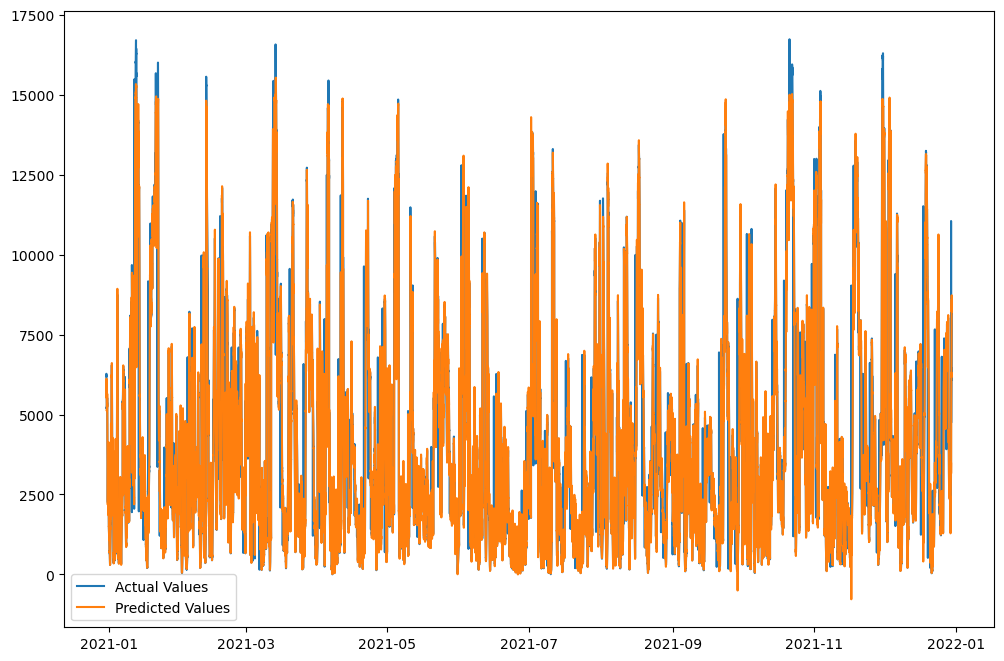

In [133]:
 plt.figure(figsize=(12, 8))
plt.plot(y_test_df.index, y_test_df['y_true'], label='Actual Values')
plt.plot(y_test_df.index, y_test_df['predictions'], label='Predicted Values')
plt.legend()
plt.show()

**Вывод:** Для прогнозирования временного ряда на год вперед была использована регрессионная модель CatBoost. Датасет был обогащен новыми признаками, были подобраны лучшие параметры модель, используя  RandomizedSearchCV. Метрика качества прогноза на год (MAPE) составила 6,98%. Из графика видно, что модель очень хорошо уловила основные тенденции временного ряда.